IMPORTAZIONI E INIZIO EXPLORATORY DATA ANALYSIS

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt


from matplotlib.pyplot import figure 
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split


#Let's begin our project reading our CSV file 
df = pd.read_csv('/Users/giuspru/Documents/Università/Magistrale/ML/PROGETTO/diabetes_prediction_dataset.csv' ,\
     index_col = False , sep=',')
cols = df.columns.values

print(df.info())
print(df.describe())
print(df.head(5))
print(cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.6

Dal primissimo studio effettuato ci accorgiamo che il nostro dataset presenta 8 features e ben 100000 campioni.
In nessuna delle 8 features sono presenti elementi nulli, tutti i valori sono presenti.
La feature gender ha un data type "Object" questo perchè pandas non gestisce stringhe e le vede come oggetti generici. 
Di seguito verificheremo che i valori della colonna siano esclusivamente Female e Male e successivamente si valuterà se dummizzare la variabile.

Si noti che anche la colonna "smoking_hystory" presenta un datatype oggetto, è necessario procedere con un investigazione per capire quali sono i possibili valori e di conseguenza procedere con una corretta rivalutazione di questi.


['Female' 'Male' 'Other']
Female    58552
Male      41430
Other        18
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='Count'>

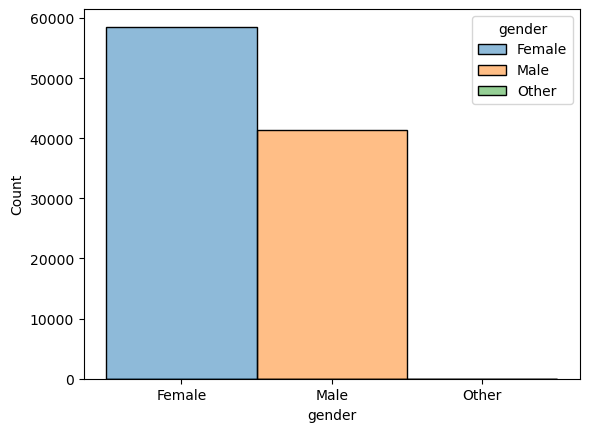

In [3]:
print(df['gender'].unique())
print(df['gender'].value_counts())


#Rappresentiamo graficamente quello appena visto:
sns.histplot(data=df , hue="gender" , x = 'gender')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 99982 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               99982 non-null  object 
 1   age                  99982 non-null  float64
 2   hypertension         99982 non-null  int64  
 3   heart_disease        99982 non-null  int64  
 4   smoking_history      99982 non-null  object 
 5   bmi                  99982 non-null  float64
 6   HbA1c_level          99982 non-null  float64
 7   blood_glucose_level  99982 non-null  int64  
 8   diabetes             99982 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.6+ MB
None


<AxesSubplot:xlabel='gender', ylabel='Count'>

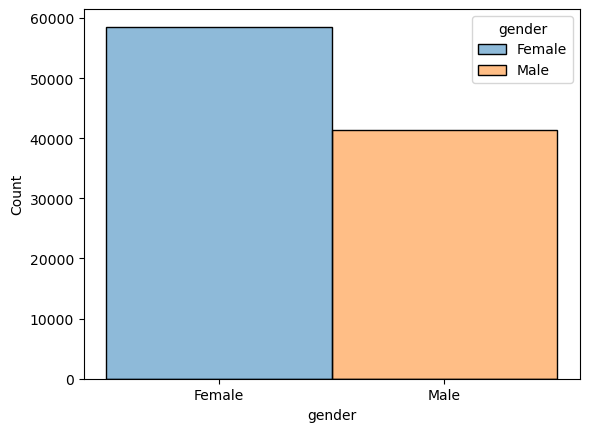

In [4]:
#Visto che il numero di soggetti per i quali il valore del gender non risulta essere binario è molto basso, solo 18 soggetti su 100000, si 
#è deciso di eleminare dal dataset questi casi. 

df.drop(df[df['gender']=='Other'].index , inplace=True)
print(df.info())
sns.histplot(data=df , hue="gender" , x = 'gender')



['never' 'No Info' 'current' 'former' 'ever' 'not current']
No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: smoking_history, dtype: int64


<AxesSubplot:xlabel='smoking_history', ylabel='Count'>

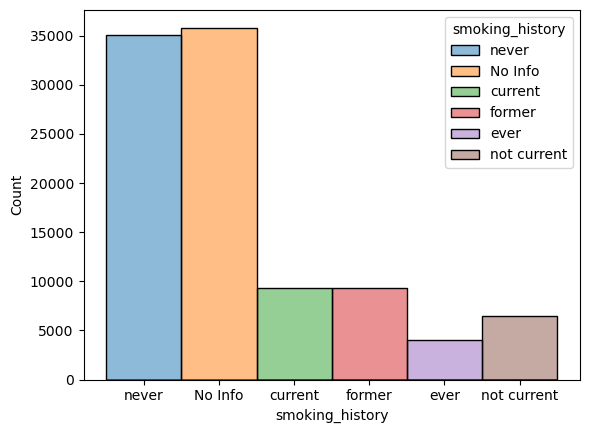

In [5]:
print(df['smoking_history'].unique())
print(df['smoking_history'].value_counts())

#Rappresentazione grafica di quello appena scritto:
sns.histplot(data=df , hue="smoking_history" , x = 'smoking_history')


Come si può ben vedere l'istogramma riportato di sopra, ha differenti possibili valori, si decide di gestire i dati nel seguente modo.
Tutti gli elementi che non appartengono ai bins "never" e "no info" verranno trattatti come fumatori.
In secondo luogo vedremo come gestire i dati caratterizzati come "No Info".

['never' 'No Info' 'Smoker']


<AxesSubplot:xlabel='smoking_history', ylabel='Count'>

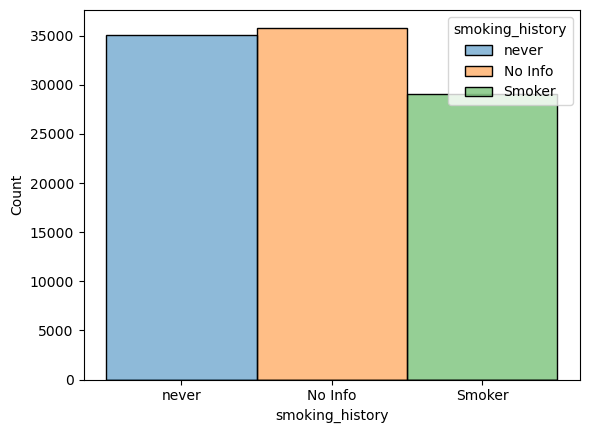

In [6]:
df['smoking_history']  = df['smoking_history'].apply(lambda x : 'Smoker' if x in ['current' , 'former' , 'ever' , 'not current'] else x )
print(df['smoking_history'].unique())
sns.histplot(data=df , hue="smoking_history" , x = 'smoking_history')


A questo punto c'è da capire se questi valori li posso lasciare cosi come sono, effettuando una dummizzazione delle variabili, oppure fare un po di features engineering.
Avrei in mente la seguente cosa: Dai dati istat del 2021 si ha che tra le persone aventi più di 14 anni la percentuale di fumatori è del 19%.
Dato che il dataset a disposizione è molto grande, potrei immaginare che tra le persone di cui non si hanno informazioni, il 19% risultino essere fumatori mentre l'81% no. 

L'idea è la seguente, faccio uno shuffle randomico del mio dataset, e per i primi 1897 campioni sostituisco al posto di No Info --> Smoker mentre algi altri No Info --> never 

never     66821
Smoker    33161
Name: smoking_history, dtype: int64


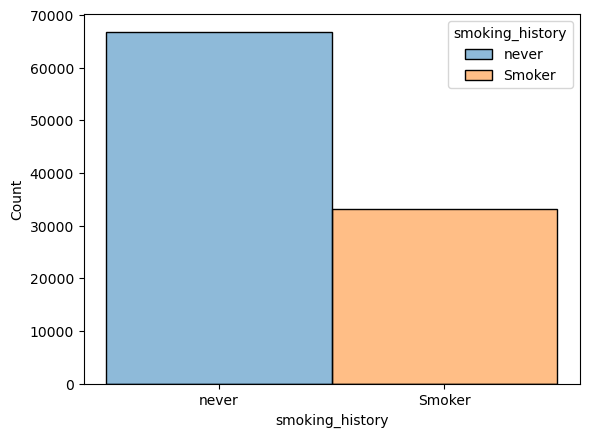

In [7]:
#come prima cosa faccio una piccola modifica al dataset, imponendo che tutti i pazienti registrati con età inferiore o uguale a 14 anni, e che presentano come valore No Info, vengano modificati con never.
df.loc[df["age"] <= 14 , "smoking_history"] = "never"

def sostituisci(riga):
    if riga["smoking_history"] == "No Info":
        return np.random.choice(["Smoker" , "never"] , p = [0.19 , 0.81])
    else:
        return riga["smoking_history"]
    
df["smoking_history"] = df.apply(sostituisci , axis=1)


sns.histplot(data=df , hue="smoking_history" , x = 'smoking_history')
print(df["smoking_history"].value_counts())
#Una cosa interessante è che in questo modo non si rispecchia la percentuale ISTAT, dalla quale eravamo partiti, ma si ha un vavlore molto piu alto, circa dell 33%, forse sarebbe meglio trasformare tutti i campioni con valore 
#No Info in non fumatori.


A questo punto volgio capire se il mio dataset risulti o meno essere sbilanciato per quanto riguarda la classe Diabete(0,1). 
Capire questo aspetto è di grande importanza, dato che successivamente nel momento dell'allenameto utilizzare F1 Score piuttosto che L'Accuracy può portarci ad una maggiore sicurezza nella valutazione dell'errore.

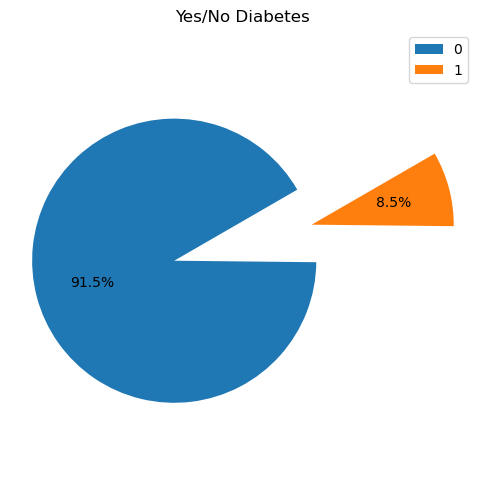

In [8]:
plt.figure(figsize=(6, 6))
plt.pie(df.diabetes.value_counts(), 
            df.diabetes.value_counts().index, 
            autopct='%1.1f%%', 
            startangle=30)
plt.axis('equal')
plt.legend(df.diabetes.value_counts().index, loc='best')
plt.title('Yes/No Diabetes')
plt.show()

Come Si puo ben vedere dal grafico riportato qui sopra, c'è una forte disparità tra persone con il diabete e persone non affette dal diabete.
IN particolar modo il 91.5% delle persone campionate sono sane, mentre l' 8.5% invece risultano avere almeno una forma di Diabete.
Alla luce di questa disparità si è deciso di optare per la metrica F1 SCORE, indicato proprio per casi che presentano un disequilibrio del dataset.


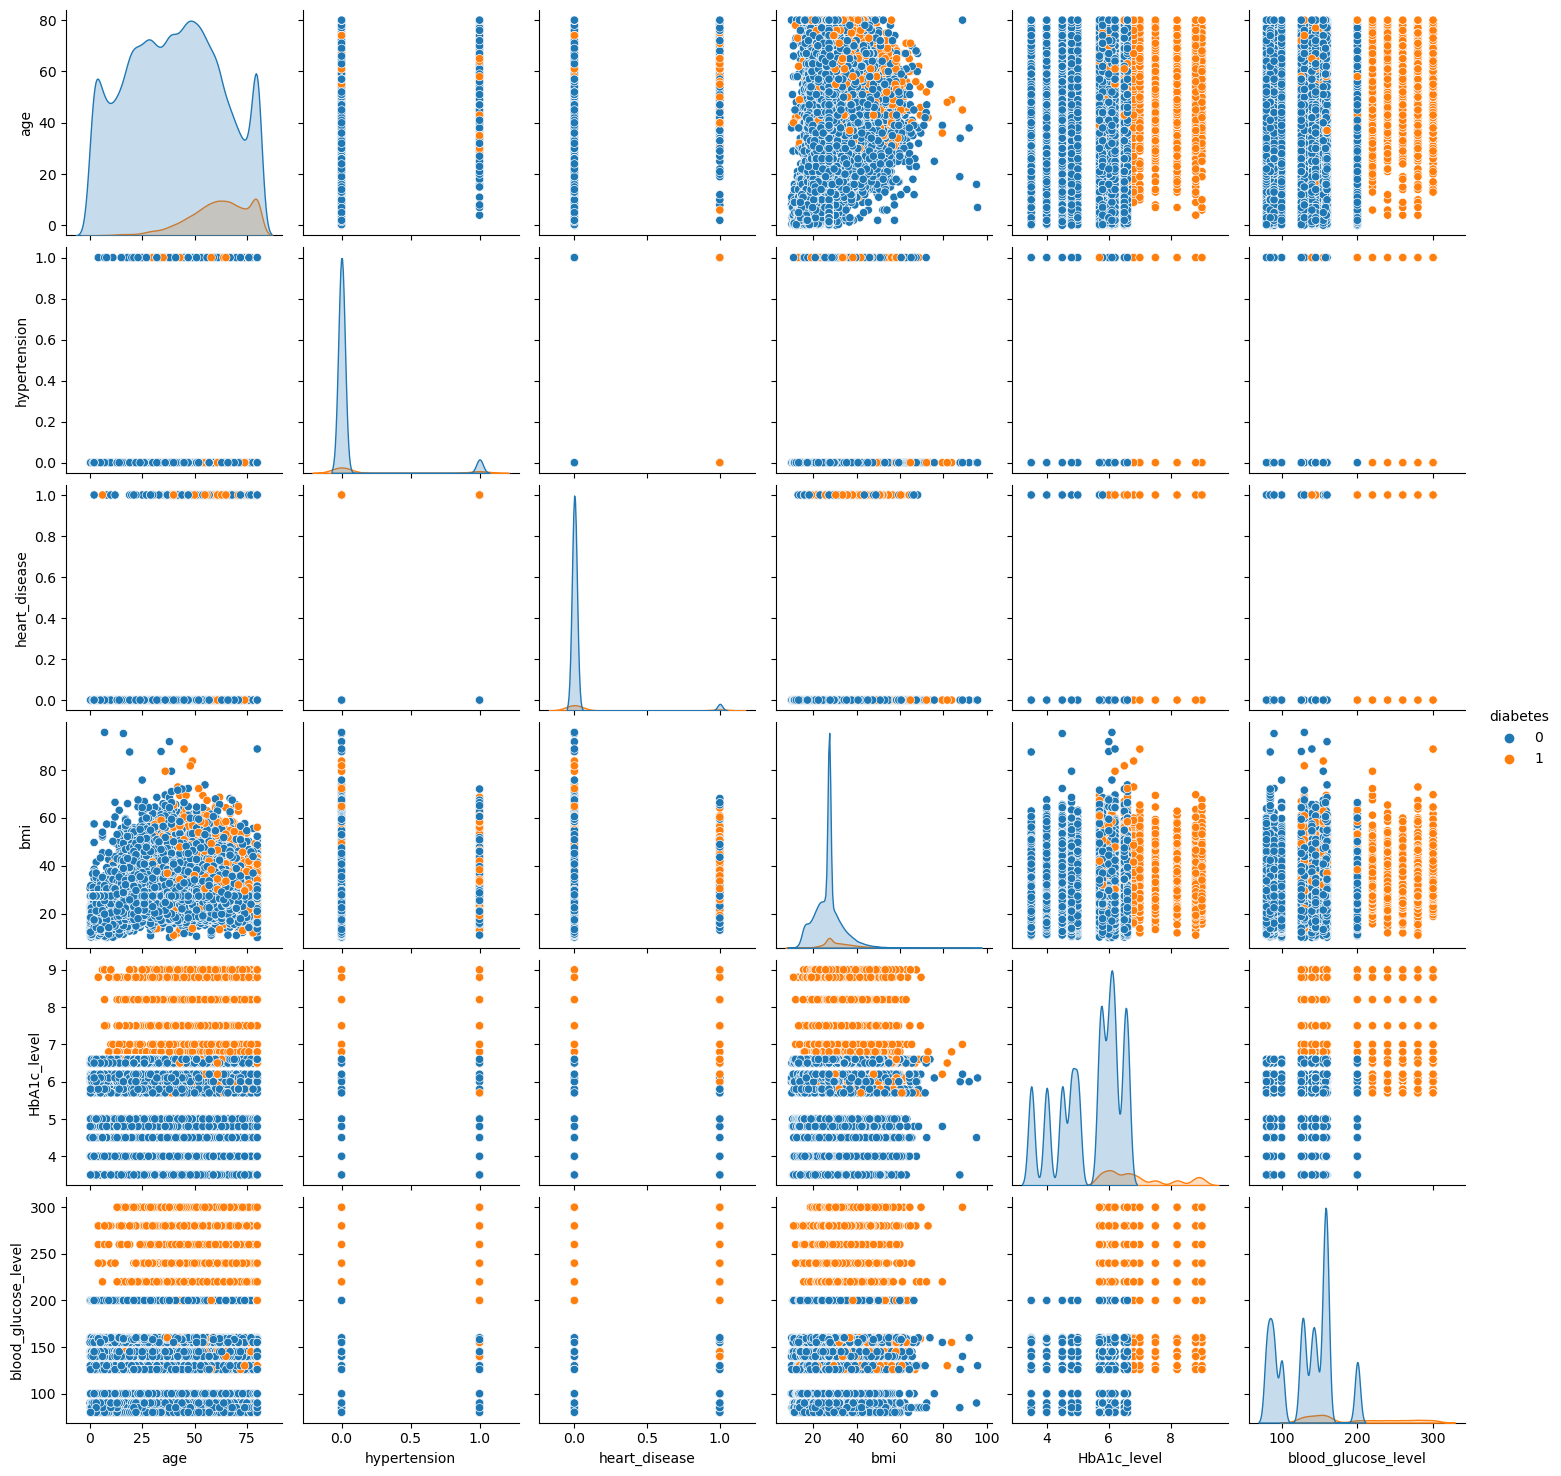

In [9]:
#Effettuo un Pairplot:
sns.pairplot(df , hue="diabetes")
plt.show()

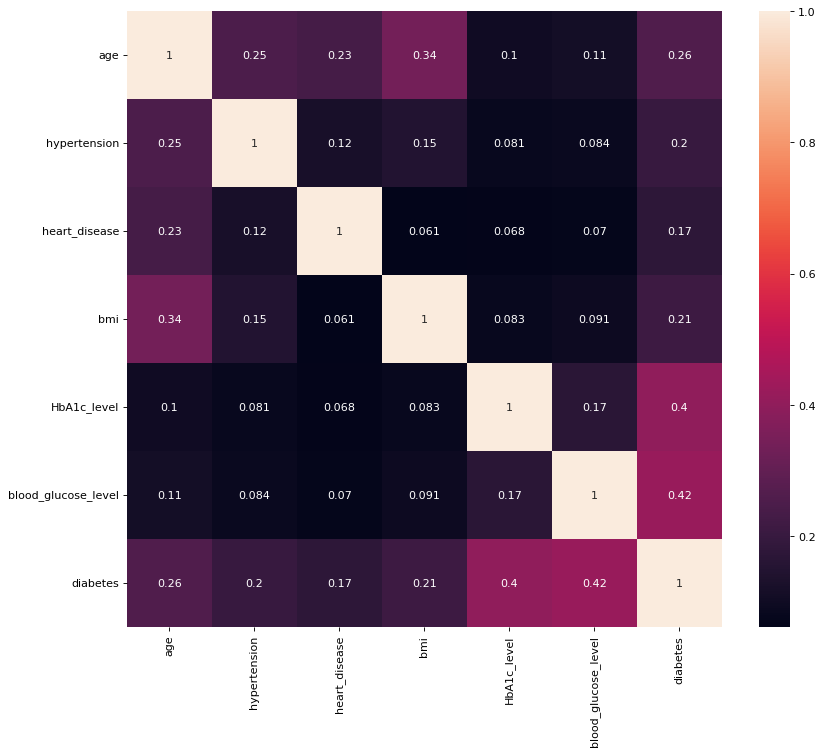

In [10]:
#Calcolo la correlation Matrix:
figure(figsize=(12,10) , dpi = 80)
corr_df = df.corr()
sns.heatmap(corr_df , annot=True)
plt.show()

In [11]:
#Procediamo Dummizzando 2 features "gender" e "Smoking_History": 
columns_to_encode = ["gender" , "smoking_history"]
df = pd.get_dummies(df , columns=columns_to_encode)
print(df.head(5))
print(df.describe())

#mi serviva per capire una cosa...
#df_shufled = df.sample(frac=1).reset_index(drop=True)
#print(df_shufled.head(5))
#print(df_shufled.describe())


    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  smoking_history_Smoker  \
0         0              1            0                       0   
1         0              1            0                       0   
2         0              0            1                       0   
3         0              1            0                       1   
4         0              0            1                       1   

   smoking_history_never  
0                      1  
1                      1  
2                      1  
3 

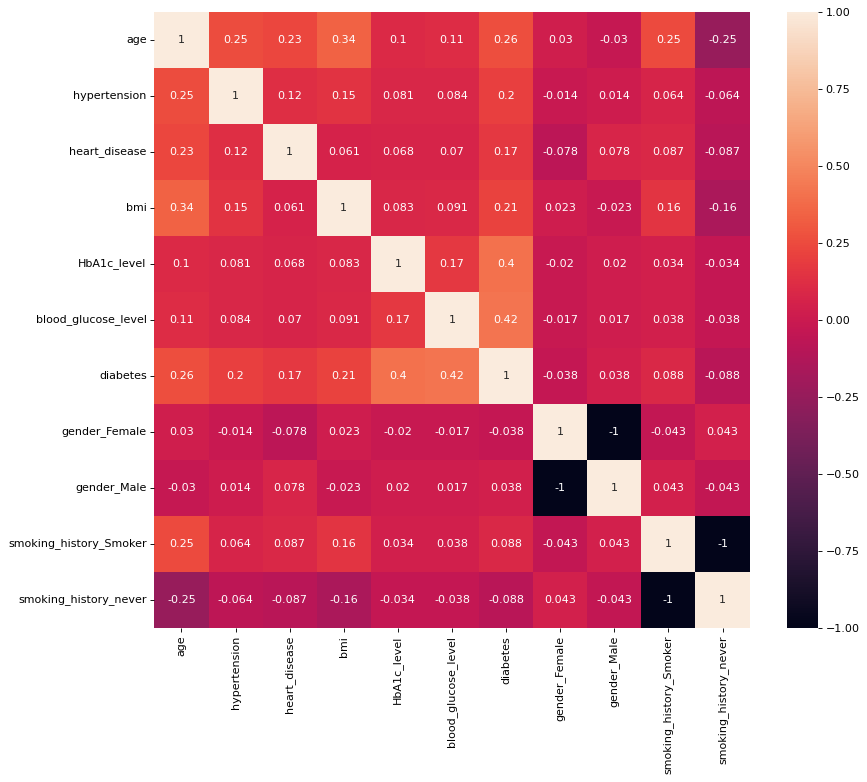

In [12]:
#Ricalcolo la COrrelation Matrix, tenedno conto della dummizzazione:
figure(figsize=(12,10) , dpi = 80)
corr_1_df = df.corr()
sns.heatmap(corr_1_df , annot=True)
plt.show()

DIVISIONE DEL DATASET: PREPARAZIONE ALL'ALLENAMENTO DEL MODELLO.

In [13]:
#Come si è visto in prima istanza nella descrizione del dataset, questo risulta essere molto ricco di campioni (100.000 campioni)
#Si è deciso pertanto di non optare per una cross validation per quanto riguarda la model selection, ma di farne una dimensione fissa.
#Si procederà a dividere il dataset nel seguente modo: Training_Set --> 70%  , Validation_set --> 10%  , Deployment_Set --> 10%  , Test_Set --> 10% 

df = df.sample(frac=1).reset_index(drop=True)


X = df.drop(["diabetes"] , axis=1)
t = df["diabetes"]

print(X.shape)
print(t.shape)
#print(t.shape[0])

training_split = 0.70
validation_split = 0.80
deployment_split = 0.90 

tr_size = int(training_split * X.shape[0])
#print(tr_size)
val_size = int(validation_split * X.shape[0])
#print(val_size)
depl_size = int(deployment_split * X.shape[0])
#print(depl_size)

X_tr = X[0 : tr_size]
t_tr = t[0 : tr_size]
print(X_tr.shape)
print(t_tr.shape)
print("###############################")

X_val = X[tr_size : val_size]
t_val = t[tr_size : val_size]
X_val.reset_index(drop=True , inplace=True)
t_val.reset_index(drop=True , inplace=True)
print(t_val.shape)
print(X_val.shape)
print(t_val.head(5))
print("###############################")

X_depl = X[val_size : depl_size]
t_depl = t[val_size : depl_size]
X_depl.reset_index(drop=True , inplace= True)
t_depl.reset_index(drop=True , inplace=True)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
print(X_depl.shape)
print(t_depl.shape)
print(t_depl.head(5))
print("###############################")

X_te = X[depl_size:]
t_te = t[depl_size:]
X_te.reset_index(drop=True , inplace=True)
t_te.reset_index(drop=True , inplace=True)
print(X_te.shape)
print(t_te.shape)
print(t_te.head(5))
print("###############################")

(99982, 10)
(99982,)
(69987, 10)
(69987,)
###############################
(9998,)
(9998, 10)
0    0
1    0
2    0
3    0
4    0
Name: diabetes, dtype: int64
###############################
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(9998, 10)
(9998,)
0    0
1    0
2    0
3    0
4    1
Name: diabetes, dtype: int64
###############################
(9999, 10)
(9999,)
0    0
1    0
2    0
3    0
4    0
Name: diabetes, dtype: int64
###############################


Si procede alla normalizzazione delle Features: un paio di accortezze.
- le features che andrò a normalizzare mediante l'algoritmo del min-maax scalere sono esclusivamente quelle non binarie, ovvero quelle in cui sono presenti valori numererici non categorici. 
- Inoltre si vuole specificare che la normalizzazione delle features, non viene fatta perchè i valori relativi a features differenti sono estremamanete differenti per ordine di grandezza, ma lo si fa per ottimamizzare i processi iterativi, per la valutazione dei parametri ottimi del modello 

In [14]:
print(df.head(5))
print(df.columns)

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  21.0             0              0  27.32          5.7                  140   
1  46.0             0              0  29.49          5.7                  126   
2  35.0             0              0  27.32          4.8                   80   
3  21.0             0              0  27.32          5.7                  160   
4  21.0             0              0  26.05          6.0                   90   

   diabetes  gender_Female  gender_Male  smoking_history_Smoker  \
0         0              1            0                       0   
1         0              0            1                       1   
2         0              0            1                       0   
3         0              1            0                       0   
4         0              0            1                       0   

   smoking_history_never  
0                      1  
1                      0  
2                      1  
3 

In [15]:
#Normalizzazione del train set:
temporaneo = X_tr[['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never']]
X_tr_normalizzare = X_tr.drop(['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never'] , axis=1)


scaler = MinMaxScaler()
X_tr_normalizzato = scaler.fit_transform(X_tr_normalizzare)
X_tr_normalizzato = pd.DataFrame(X_tr_normalizzato , columns=["age" , "bmi" , 'HbA1c_level' , 'blood_glucose_level' ])


X_tr_final = pd.concat([ X_tr_normalizzato.reset_index(drop=True) , temporaneo.reset_index(drop=True)] , axis=1 )

print(t_tr.shape)
print(X_tr_normalizzato.shape)
print(temporaneo.shape)
print(X_tr_final.shape)







(69987,)
(69987, 4)
(69987, 6)
(69987, 10)


In [16]:
#Normalizzazione del Validation set:

temporaneo2 = X_val[['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never']]
temporaneo2.reset_index(drop=True, inplace=True)
#print(type(temporaneo2))
#print(temporaneo2.head(5))
#print(temporaneo2.shape[0])

X_val_normalizzare = X_val.drop(['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never'] , axis=1)

#print(X_val_normalizzare.head(5))

X_val_normalizzato = scaler.transform(X_val_normalizzare)
X_val_normalizzato = pd.DataFrame(X_val_normalizzato , columns=["age" , "bmi" , 'HbA1c_level' , 'blood_glucose_level' ])
#print(X_val_normalizzato.head(5))

#print(X_val_normalizzato.shape[0])


X_val_final = pd.concat([X_val_normalizzato.reset_index(drop=True) , temporaneo2.reset_index(drop=True)] , axis=1)
print(X_val_final.shape)
print(t_val.shape)




(9998, 10)
(9998,)


In [17]:
#Normalizzazione del Deplyment set:

temporaneo3 = X_depl[['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never']]
temporaneo3.reset_index(drop = True , inplace = True)
print(temporaneo3.head(5))

X_depl_normalizzare = X_depl.drop(['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never'] , axis=1)
print(X_depl_normalizzare.head(5))

X_depl_normalizzato = scaler.transform(X_depl_normalizzare)
X_depl_normalizzato = pd.DataFrame(X_depl_normalizzato , columns=["age" , "bmi" , 'HbA1c_level' , 'blood_glucose_level' ] )

print(X_depl_normalizzato.head(5))

X_depl_final = pd.concat([ X_depl_normalizzato.reset_index(drop=True) , temporaneo3.reset_index(drop=True)] , axis=1)
print(X_depl_final.head(5))

print("############################### \n " , X_depl_final.shape , "\n" , t_depl.shape)


   hypertension  heart_disease  gender_Female  gender_Male  \
0             0              0              1            0   
1             0              0              1            0   
2             0              0              0            1   
3             0              0              0            1   
4             1              1              0            1   

   smoking_history_Smoker  smoking_history_never  
0                       0                      1  
1                       0                      1  
2                       1                      0  
3                       0                      1  
4                       1                      0  
    age    bmi  HbA1c_level  blood_glucose_level
0  59.0  42.59          3.5                   80
1  73.0  19.02          5.7                  145
2  78.0  24.13          5.0                   80
3  19.0  30.93          4.8                   85
4  41.0  25.20          7.5                  200
        age       bmi  HbA1

In [18]:
#Normalizzazione del Test set:

temporaneo4 = X_te[['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never']]
temporaneo4.reset_index(drop = True , inplace = True)

print(temporaneo4.head(5))

X_te_normalizzare = X_te.drop(['hypertension', 'heart_disease', 'gender_Female', 'gender_Male',
       'smoking_history_Smoker', 'smoking_history_never'] , axis=1)
print(X_te_normalizzare.head(5))

X_te_normalizzato = scaler.transform(X_te_normalizzare)
X_te_normalizzato = pd.DataFrame(X_te_normalizzato , columns=["age" , "bmi" , 'HbA1c_level' , 'blood_glucose_level'])
print(X_te_normalizzato.head(5))

X_te_final = pd.concat([ X_te_normalizzato.reset_index(drop=True) , temporaneo4.reset_index(drop=True)] , axis=1)
print(X_te_final.head(5))


print("############################### \n " , X_te_final.shape , "\n" , t_te.shape)




   hypertension  heart_disease  gender_Female  gender_Male  \
0             0              0              0            1   
1             0              0              1            0   
2             0              0              1            0   
3             0              0              1            0   
4             0              0              0            1   

   smoking_history_Smoker  smoking_history_never  
0                       0                      1  
1                       0                      1  
2                       1                      0  
3                       0                      1  
4                       0                      1  
    age    bmi  HbA1c_level  blood_glucose_level
0   8.0  27.32          5.8                  200
1  73.0  25.00          4.8                   80
2  41.0  39.32          6.6                  100
3  28.0  29.16          6.6                  126
4  56.0  27.32          6.5                  200
        age       bmi  HbA1

In [19]:
#MODEL SELECTION LOGISTIC REGRESSION:

range_C = [ 0.001 , 0.003 ,0.01 , 0.03 , 0.1 , 0.3 , 1 , 3 , 10 , 30 , 100 , 300 , 1000]
f1_best = -1 
C_best = -1 
best_solver = ""


#array per grafici: 
f1_scores_tr = []
f1_scores_val = []
valori_C = []

best_predictions = []


#Ciclo per ottimizzazione degli hyperparameters: decido di non effettuare un ciclo for anche sull'hyperparameter "Solver" , lo fisso a "sag" perchè il dataset è molto grande.
for solver in ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']:
    for c in range_C:
        print("Working with Solver hyperparameter = " , solver , " and C hyperparameter = " , c , "\n")
        logistic_model = LogisticRegression(solver=solver , penalty="l2" , C=c)
        logistic_model.fit(X_tr_final , t_tr)

        #effettuo predizioni sul training
        t_hat_tr = logistic_model.predict(X_tr_final)
        f1score_tr  = f1_score(t_tr , t_hat_tr , average="macro")
    
        t_hat_val = logistic_model.predict(X_val_final)
        f1score_val = f1_score(t_hat_val , t_val , average="macro")

        valori_C.append(c)
        f1_scores_tr.append(f1_scores_tr)
        f1_scores_val.append(f1score_val)

        if f1score_val > f1_best:
            f1_best = f1score_val
            C_best = c 
            best_predictions = t_hat_val
            best_solver = solver

    



print("Il Processo ha restituito, Best F1 Score: " , f1_best , "\nValore migliore per Hyperparameter C:  " , C_best)
print("Solver migliore: " , best_solver)



Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  0.001 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  0.003 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  0.01 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  0.03 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  0.1 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  0.3 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  1 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  3 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  10 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  30 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  100 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  300 

Working with Solver hyperparameter =  lbfgs  and C hyperparameter =  1000 

Working with Solver hype

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  sag  and C hyperparameter =  30 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  sag  and C hyperparameter =  100 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  sag  and C hyperparameter =  300 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  sag  and C hyperparameter =  1000 

Working with Solver hyperparameter =  saga  and C hyperparameter =  0.001 

Working with Solver hyperparameter =  saga  and C hyperparameter =  0.003 

Working with Solver hyperparameter =  saga  and C hyperparameter =  0.01 

Working with Solver hyperparameter =  saga  and C hyperparameter =  0.03 

Working with Solver hyperparameter =  saga  and C hyperparameter =  0.1 

Working with Solver hyperparameter =  saga  and C hyperparameter =  0.3 

Working with Solver hyperparameter =  saga  and C hyperparameter =  1 

Working with Solver hyperparameter =  saga  and C hyperparameter =  3 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  saga  and C hyperparameter =  10 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  saga  and C hyperparameter =  30 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  saga  and C hyperparameter =  100 



/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Working with Solver hyperparameter =  saga  and C hyperparameter =  300 

Working with Solver hyperparameter =  saga  and C hyperparameter =  1000 

Il Processo ha restituito, Best F1 Score:  0.8611988004560378 
Valore migliore per Hyperparameter C:   3
Solver migliore:  liblinear


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


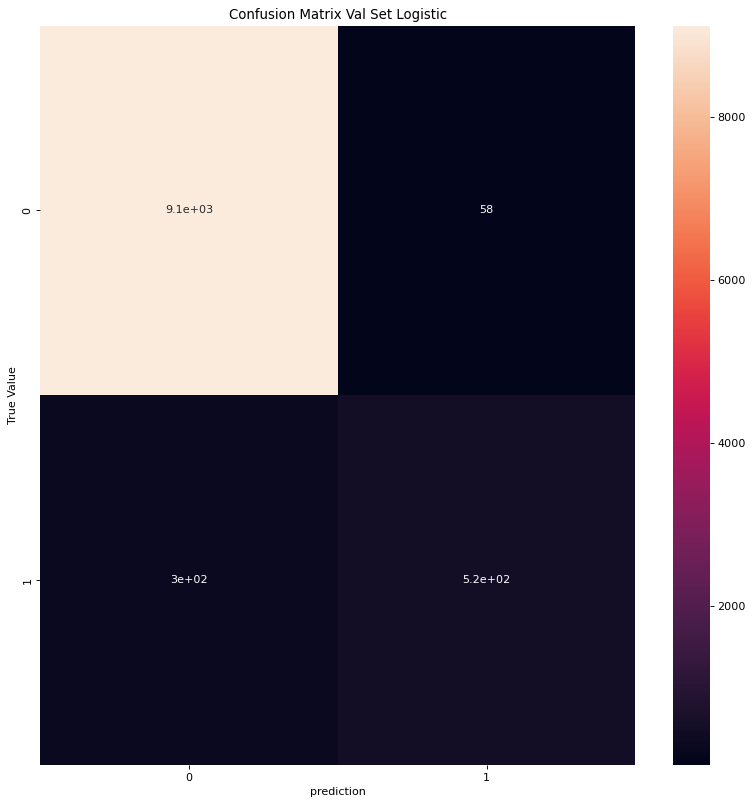

In [20]:
#Vediamo andamento dell' F1 Score:

'''fig = plt.figure()
figure(figsize=(10,10) , dpi=80)
ax = plt.gca()
ax.scatter(valori_C , f1_scores_tr)
ax.scatter(valori_C , f1_scores_val)
ax.set_xscale('log')
ax.grid(True)
plt.show()'''


#Vediamo la Confusion Matrix:
con_matrix  =confusion_matrix(t_val , best_predictions)
figure(figsize=(12,12) , dpi = 80)
hm = sns.heatmap(con_matrix, annot=True)
plt.title("Confusion Matrix Val Set Logistic")
plt.xlabel("prediction")
plt.ylabel("True Value")
plt.show()

In [28]:
#Model selection per SVM:

range_C = [0.1 , 0.3 , 1 , 3 , 10 , 30]
gamma_range = [ 0.1 , 0.3 , 1 , 3 , 10 , 30]
svm_best_f1_score  = -1 
svm_best_c = -1 
svm_best_kernel = ""
svm_best_degree  = -1
svm_best_gamma = -1


f1_scores_tr_svm = []
f1_scores_val_svm = []
par_SVM = []

best_svm_predictions = []

for kernel in ['linear' , 'poly' , 'rbf' , 'sigmoid']:
    for degree in range(1,3):
        for gamma in gamma_range:
            for c in range_C:
                print("PROCESSO CON: KERNEL= " , kernel , "DEGREE = " , degree , "GAMMA= " , gamma , "C= " , c)
                modello_SVM = SVC(kernel= kernel , C = c , gamma= gamma , degree=degree)
                modello_SVM.fit(X_tr_final , t_tr)

                t_hat_tr_svm = modello_SVM.predict(X_tr_final)
                f1_score_svm_tr = f1_score(t_tr , t_hat_tr_svm , average='macro')
                t_hat_val_svm = modello_SVM.predict(X_val_final)
                f1_score_svm_val  = f1_score(t_val , t_hat_val_svm , average = "macro")

                f1_scores_tr_svm.append(f1_score_svm_tr)
                f1_scores_val_svm.append(f1_score_svm_val)
                par_SVM.append(c)


                if f1_score_svm_val > svm_best_f1_score:
                    svm_best_f1_score = f1_score_svm_val
                    svm_best_c = c
                    svm_best_kernel = kernel
                    svm_best_degree = degree
                    svm_best_gamma = gamma
                    best_svm_predictions = t_hat_val_svm



print("Il Processo ha restituito, Best F1 Score: " , svm_best_f1_score , "\nValore migliore per Hyperparameter C:  " , svm_best_c)
print("Kernel migliore: " , svm_best_kernel , "\nGamma migliore: " , svm_best_gamma , "\nDegree migliore: " , svm_best_degree)

                



PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.1 C=  0.1
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.1 C=  0.3
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.1 C=  1
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.1 C=  3
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.1 C=  10
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.1 C=  30
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.3 C=  0.1
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.3 C=  0.3
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.3 C=  1
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.3 C=  3
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.3 C=  10
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  0.3 C=  30
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  1 C=  0.1
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  1 C=  0.3
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  1 C=  1
PROCESSO CON: KERNEL=  linear DEGREE =  1 GAMMA=  1 C=  3
PROCESSO CON: KERNEL=  linear DE

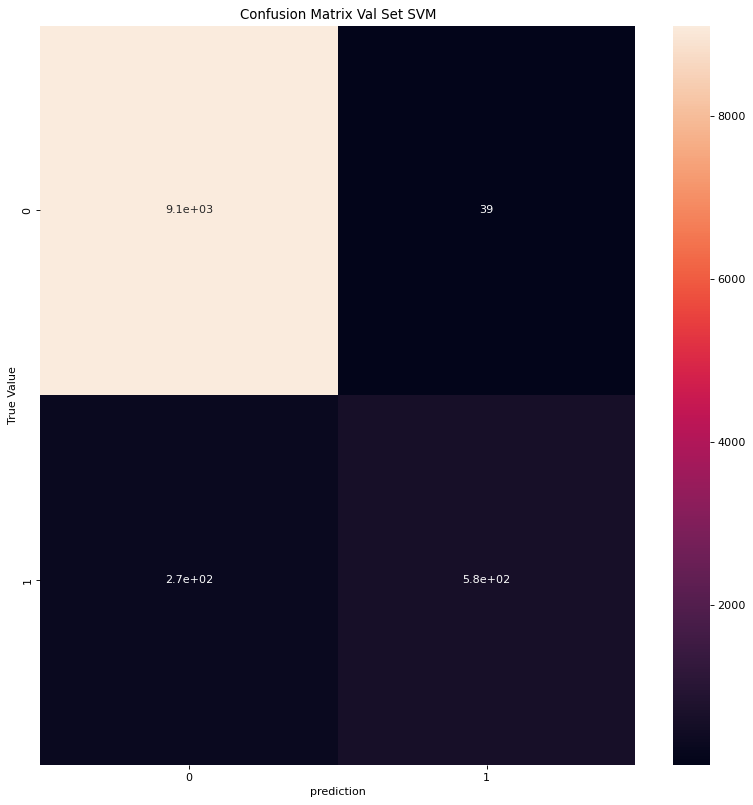

In [29]:
#Confusion Matrix SVM validation:

con_matrix_svm_val  =confusion_matrix(t_val , best_svm_predictions)
figure(figsize=(12,12) , dpi = 80)
hm = sns.heatmap(con_matrix_svm_val, annot=True)
plt.title("Confusion Matrix Val Set SVM")
plt.xlabel("prediction")
plt.ylabel("True Value")
plt.show()

In [30]:
#Con il Deployment set posso andare a effettuare un confronto tra i due modelli: 
'''Il Processo ha restituito, Best F1 Score:  0.8475829441686273 
Valore migliore per Hyperparameter C:   1
Solver migliore:  lbfgs'''


C_logistic  = 1 
Solver_logistic = "lbfgs"

C_svm = 30
gamma_svm = 30
degree_svm = 1
kernel_svm = "rbf"

logistic_model_depl = LogisticRegression(solver = Solver_logistic , penalty="l2" , C=C_logistic)
logistic_model_depl.fit(X_tr_final , t_tr)
t_pred_logistic = logistic_model_depl.predict(X_depl_final)
f1_score_logistic_depl = f1_score(t_depl , t_pred_logistic , average= "macro")


svm_model_depl = SVC(kernel= kernel_svm, C= C_svm , degree= degree_svm , gamma= gamma_svm)
svm_model_depl.fit(X_tr_final , t_tr)
t_pred_svm = svm_model_depl.predict(X_depl_final)
f1_score_svm_depl = f1_score(t_depl , t_pred_svm , average="macro")


print("F1 score per il modello LOGISTIC REGRESSION: " , f1_score_logistic_depl )
print("F1 score per il modello SVM: " , f1_score_svm_depl)




F1 score per il modello LOGISTIC REGRESSION:  0.8506986300547498
F1 score per il modello SVM:  0.8860685965771415


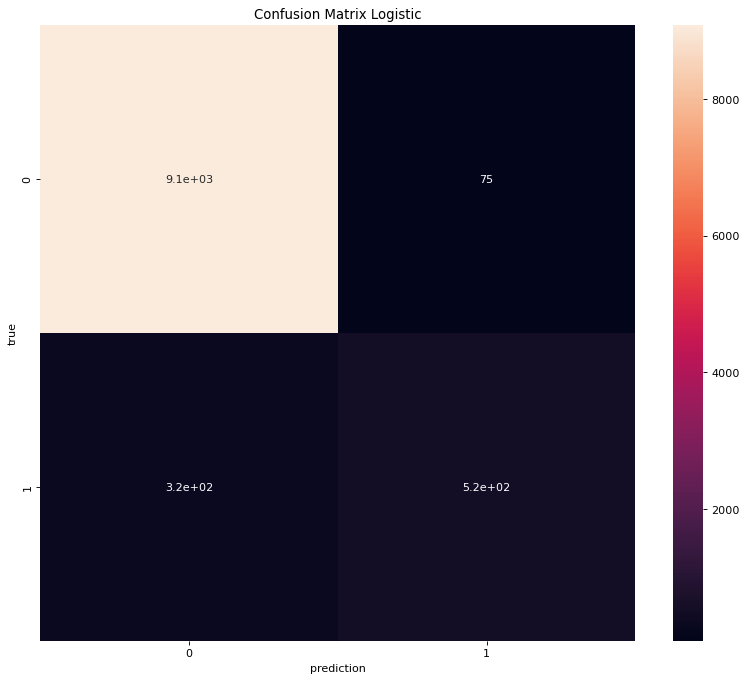

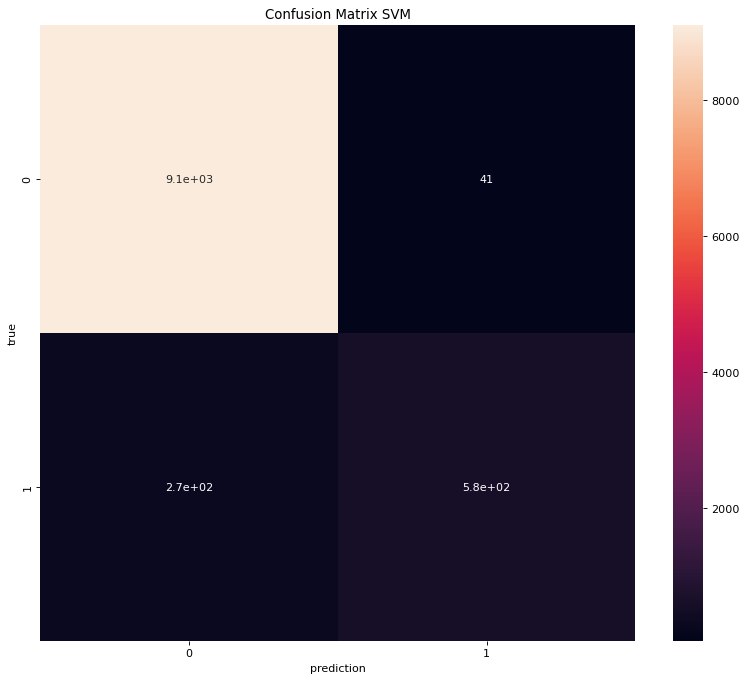

In [31]:
#facciamo le confusion matrix dei due 

cm_depl_logistic = confusion_matrix(t_depl, t_pred_logistic)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm_depl_logistic, annot=True)
plt.title('Confusion Matrix Logistic')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()


cm_depl_svm = confusion_matrix(t_depl , t_pred_svm)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm_depl_svm, annot=True)
plt.title('Confusion Matrix SVM')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()

In [32]:
#predizione sul test set:

svm_test_model = SVC(kernel= kernel_svm, C= C_svm , degree= degree_svm , gamma= gamma_svm)
svm_test_model.fit(X_tr_final , t_tr)
t_hat_test_svm = svm_test_model.predict(X_te_final)
f1_score_test = f1_score(t_te , t_hat_test_svm , average= 'macro')

print("l'F1 Score finale, calcolato su lTEST SET è: " , f1_score_test)

l'F1 Score finale, calcolato su lTEST SET è:  0.8866370143490772


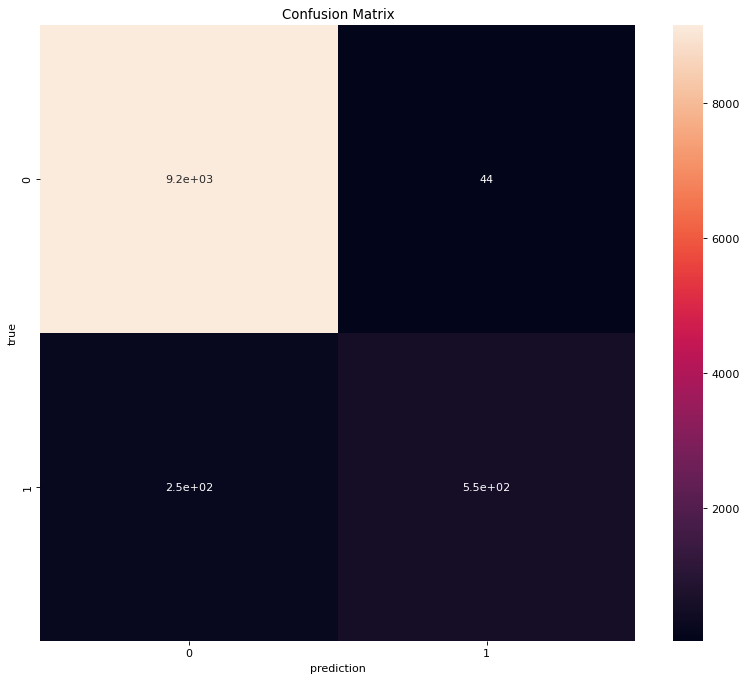

In [33]:
cm_test = confusion_matrix(t_te , t_hat_test_svm)
figure(figsize=(12, 10), dpi=80)
hm = sns.heatmap(cm_test, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('prediction')
plt.ylabel('true')
plt.show()